# OpenCV, Tesseract를 활용한 번호판 인식

- ### 필요한 라이브러리를 import 한다.

In [1]:
import numpy as np
import cv2
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt

- #### Tesseract OCR 경로 지정 (Windows 버전)

In [2]:
tesseract_path = 'C:/Program Files (x86)/Tesseract-OCR'
pytesseract.pytesseract.tesseract_cmd = tesseract_path + '/tesseract'

- #### imread 함수를 통해 t1.jpg 이미지 파일을 읽어들인다.

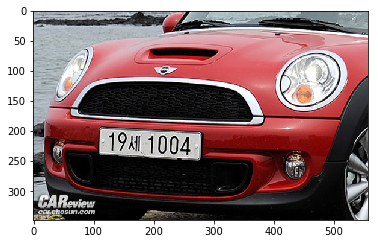

In [3]:
image = cv2.imread('t1.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

- #### 이미지 사이즈를 조정 한다.

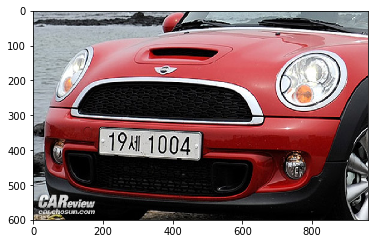

In [4]:
dim = (int(image.shape[1] * 600.0 / image.shape[0]), 600)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

- #### GrayScale 이미지로 변환

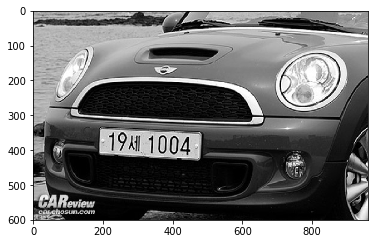

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray')

- #### 가우시안 블러를 통해 블러 처리. 11x11 kernel

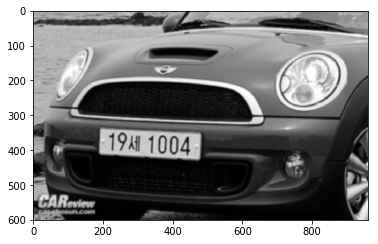

In [6]:
blur = cv2.GaussianBlur(gray, (11, 11), 0)
plt.imshow(blur, 'gray')

- #### 직사각형의 점들을 일관되게 정렬

In [7]:
def order_points(pts):
    # 0:top-left, 1:top-right, 2:bottom-right, 3:bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    
    # 
    s = pts.sum(axis = 1)
    # Top Left, 가장 작은 sum 값
    rect[0] = pts[np.argmin(s)]
    # Bottom Right, 가장 큰 sum 값
    rect[2] = pts[np.argmax(s)]
    
    # point 간의 차이를 계산함
    diff = np.diff(pts, axis = 1)
    # Top Right, 가장 작은 차이 값
    rect[1] = pts[np.argmin(diff)]
    # Bottom Left, 가장 큰 차이 값
    rect[3] = pts[np.argmax(diff)]
    return rect

- #### ADAPTIVE_THRESH_MEAN_C 형식으로 임계처리.

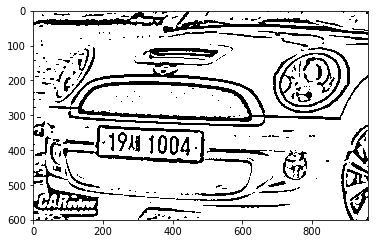

In [8]:
threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)
plt.imshow(threshold, 'gray')

- #### 최소 75, 최대 200 값 사이 범위로 edge 처리

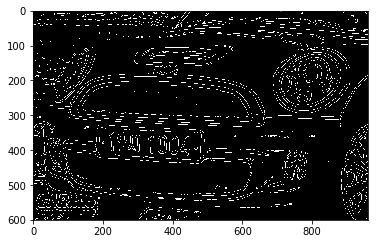

In [9]:
edged = cv2.Canny(threshold, 75, 200)
plt.imshow(edged, 'gray')

- #### findContous 함수를 통해 관심 contours를 받는다.

In [10]:
_, contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

- #### 번호판을 찾아 OCR 통해 Text로 변환

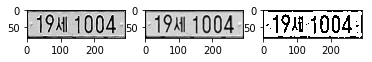

text :  19-1004:


-1

In [11]:
index = 0
for contour in contours:
    contourArea = cv2.contourArea(contour)
    
    # 크기가 200 이상인 것들만 허용
    if contourArea > 200:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)         

        # 꼭지점이 4개 인것만 허용
        if len(approx) == 4:                               
            rect = cv2.minAreaRect(contour)                
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            x, y, w, h = cv2.boundingRect(box)
            aspect_ratio = float(w)/h

            # 가로 세로 비율이 아래와 같은 지정 범위 인것들만 허용
            if aspect_ratio < 5 and aspect_ratio >= 2:
                count = 0

                for hier in hierarchy[0]:
                    if hier[3] == index:
                        count = count + 1

                # 내부에 최소 6개 ~ 15개 사이의 child가 존재해야함
                if count > 6 and count < 15:
                    
                    # 검출된 번호판 투영변환
                    rect = order_points(box.reshape(4, 2))
                    (topLeft, topRight, bottomRight, bottomLeft) = rect
                    w1 = abs(bottomRight[0] - bottomLeft[0])
                    w2 = abs(topRight[0] - topLeft[0])
                    h1 = abs(topRight[1] - bottomRight[1])
                    h2 = abs(topLeft[1] - bottomLeft[1])
                    maxWidth = max([w1, w2])
                    maxHeight = max([h1, h2])
                    dst = np.float32([[0,0], [maxWidth-1,0], [maxWidth-1,maxHeight-1], [0,maxHeight-1]])
                    M = cv2.getPerspectiveTransform(rect, dst)
                    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

                    # 변환된 번호판 저장
                    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
                    blur = cv2.GaussianBlur(gray, (5, 5), 0)
                    threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)
                    cv2.imwrite('license_plate.png', threshold)
                    
                    plt.subplot(1, 3, 1)
                    plt.imshow(gray, 'gray')
                    plt.subplot(1, 3, 2)
                    plt.imshow(blur, 'gray')
                    plt.subplot(1, 3, 3)
                    plt.imshow(threshold, 'gray')
                    plt.show()
                    
                    # OCR로 텍스트 변환
                    license_plate_image = Image.open('license_plate.png')                    
                    text = pytesseract.image_to_string(license_plate_image)                    
                    print('text : ', text)
                        
    index = index + 1
    
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)